In [1]:
import mlflow
from mlflow.tracking.client import MlflowClient

from rich import print
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import ray
import os
import matplotlib.pyplot as plt

from ddistexps.utils import format_vertical_headers
import sys
sys.path.append(os.path.abspath("./utils.py")) 

from ccutils.utils import get_all_runs, get_pareto_frontier
from ccutils.inference import cluster_runs, summarize_ensembled_predictions 
from ccutils.plot import plot_ensemble_pareto_movement

%load_ext autoreload
%autoreload 2
# sns.set_theme(style="whitegrid")  
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
ray.init(namespace='DataFlow', ignore_reinit_error=True)

[2024-05-06 21:13:00,218] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2024-05-06 21:13:00,858	INFO worker.py:1432 -- Using address localhost:4004 set in the environment variable RAY_ADDRESS
2024-05-06 21:13:00,873	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 104.171.203.248:4004...
2024-05-06 21:13:00,970	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

# Ensemble Pareto Set

We augment the pareto frontier by adding ensemble models; this will show us
if the accuracy gain for additional floating point operations (utility) is better
for ensemble or fixed models (i.e. should be spend flops on ensembling or on a better model) 

Constructing ensembles:
1. Pick a $k$, the number of ensembles to create on the pareto front.
2. Divide (min-acc, max-acc) into $k$ roughly equal internvals that include the two end-points. Pick the models on the pareto frontier closest in accuracy
to these points and pick their (flops, acc) values as cluster centers.
3. Pick the $s$ size of the ensemble (number of models in ensemble).
4. Assign runs to cluster based on their (flops, accuracy) to form ensembles.

In [2]:
# Define the relevant experiments here; Dataset -> [Experiment names]
EXPERIMENTS = {
    'CIFAR10': {
        'expnames': ['baseline/cifar10-small', 'baseline/cifar10-large',
        'distillation/cifar10-small'],
        'ds_kwargs': {'ds_name': 'CIFAR10Eval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    #'CIFAR100': ['baseline/cifar100-small', 'baseline/cifar100-large', 'distillation/cifar100-small'],
    'ImageNet1k': {
        'expnames': ['baseline/imagenet-small', 'baseline/imagenet-sanity'],
        'ds_kwargs': {'ds_name': 'ImageNet1kEval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    'TinyImageNet': [],
}

In [3]:
ds_names = ['CIFAR10', 'ImageNet1k']
results_buffer = {}
for ds_name in ds_names:
    print(ds_name)
    all_runs = get_all_runs(EXPERIMENTS[ds_name]['expnames'])
    all_runs = cluster_runs(all_runs, 8)
    pareto_runs = get_pareto_frontier(all_runs)
    ensemble_df = summarize_ensembled_predictions(all_runs, EXPERIMENTS)
    results_buffer[ds_name] = {'all_runs': all_runs, 'pareto_runs':
                               pareto_runs, 'ensemble_df': ensemble_df}

CIFAR10

num-runs: 271
metrics.val_acc_best      0
metrics.artifact_flops    0
dtype: int64
Waiting for inference (map).


(get_model_predictions pid=2837571) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval
(get_model_predictions pid=2837569) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval
(get_model_predictions pid=2837574) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval
(get_model_predictions pid=2837572) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(get_model_predictions pid=2837579) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval
(get_model_predictions pid=2837570) Found existing actor: Actor(DataFlow, ef52b154a9ed8af244fe7b4e01000000) --> DF-CIFAR10Eval
(get_model_pre

 0:   0%|          | 0/19 [00:00<?, ?it/s]

Waiting for ensemble computation (reduce)


 0:   0%|          | 0/7 [00:00<?, ?it/s]

ImageNet1k

num-runs: 154
metrics.val_acc_best      5
metrics.artifact_flops    0
dtype: int64
Waiting for inference (map).


 0:   0%|          | 0/21 [00:00<?, ?it/s]

Waiting for ensemble computation (reduce)


 0:   0%|          | 0/7 [00:00<?, ?it/s]

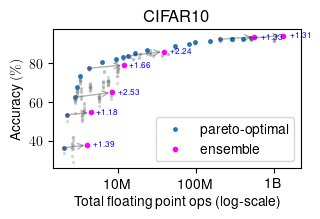

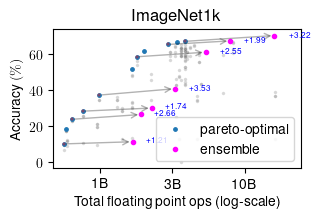

In [4]:
for ds_name, data in results_buffer.items():
    all_runs, pareto_runs = data['all_runs'], data['pareto_runs']
    ensemble_df = data['ensemble_df']
    fig, ax = plot_ensemble_pareto_movement(ds_name, all_runs, pareto_runs,
                                            ensemble_df, figsize=(3.2, 1.8),
                                            markersize=6)
    fig.savefig(f"../imgs/ensemble-pareto-flops-acc-{ds_name}.pdf", bbox_inches='tight')